In [1]:
import sys
sys.path.append("/Isolation-Forest-For-Fraud-Detection/src/")
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from src.preprocessing.data import read_all_trx, train_test_split_transactions
from src.preprocessing.features import create_feature_matrix
from src.model.performance import evaluate_model, random_search_cv,time_window_cv
from src.preprocessing.helpers import scenario_sample
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
#______________________________ DATA______________________________________
start = '2018-04-01'
end = '2018-09-30'
calendar = pd.date_range(start, end, inclusive="both").strftime('%Y-%m-%d')
root = "https://github.com/Fraud-Detection-Handbook/simulated-data-raw/blob/main/data/"
path_data = [f"{root}{date}.pkl?raw=true" for date in calendar]
transactions_df = read_all_trx(path_data).sort_values('TX_DATETIME').reset_index(drop=True)
scenario_1 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 1]
scenario_2 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 2]
scenario_3 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 3]
#_________________________________________________________________________

Execution time: 171.34277200698853 seconds


In [61]:
scenario_1.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1
5789,5790,2018-04-01 13:31:48,4944,6050,222.26,48708,0,1,1
6549,6549,2018-04-01 14:42:02,4625,9102,226.40,52922,0,1,1
10354,10355,2018-04-02 05:03:35,2513,1143,222.04,104615,1,1,1
10749,10749,2018-04-02 06:06:00,3770,5671,264.95,108360,1,1,1


In [6]:
transactions_df.shape

(1754155, 9)

In [4]:
#__________________________ FEATURES _________________________________
X = create_feature_matrix(transactions_df,windows_size_in_days = [1,5,7,15,30],delay_period=7)
target = "TX_FRAUD"

index = "TX_DATETIME"

train_period = "2018-07-01"

customer_features = [i for i in X.columns if "CUSTOMER_ID_" in i]

flag_features = [i for i in X.columns if "TX_FLAG_" in i]

terminal_features = [i for i in X.columns if "TERMINAL_ID_" in i]

time_features = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_MONTH', 'TX_DAY', 'TX_HOUR', 'TX_MINUTE', 'TX_DURING_WEEKEND',
                 'TX_DURING_NIGHT']

helper_columns = ['TX_FRAUD', 'TX_FRAUD_SCENARIO', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID']

features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features
#___________________________________________________________________

Execution time: 217.98134803771973 seconds
Execution time: 121.00021052360535 seconds
Execution time: 7.047279596328735 seconds
Execution time: 351.19940733909607 seconds


In [ ]:
#______________________________ TIME WINDOW SPLIT____________________________
model = IsolationForest()
results_ts = time_window_cv(transactions_df,model,features)
#____________________________________________________________________________

In [ ]:
results_ts.columns

In [ ]:
s = results_ts["validation"][1].round(2)
s.index = ['isolation forest','dummy model','random guess']

time_props = "Validation of Sliding Time Window"
legend_props = "Train:05-07;Test:08-09"
my_cmap = sns.light_palette("Blue", as_cmap=True)
fig, ax = plt.subplots(layout='constrained',figsize=(10, 4))
ax.set_title(f"{time_props}")
ax.set_xlabel("AUC")
colorad = ["#457b9d", "#98c1d9", "#3d5a80"]
ax.barh(y = s.index,width = s.values, color=colorad[::-1])
ax.bar_label(ax.containers[0],fontsize=8, padding=3)
ax.spines[['right', 'top']].set_visible(False)
ax.legend([legend_props])

fig.savefig('auc_sliding_time_window_2.png',transparent=True)

In [ ]:
condition = transactions_df["TX_DATETIME"].between(results_ts.loc[0,"test_start"],
                                                   results_ts.loc[0,"test_end"])
transactions_df.loc[condition,"TX_FRAUD_SCENARIO"].value_counts()

In [ ]:
condition = transactions_df["TX_DATETIME"].between(results_ts.loc[1,"test_start"],
                                                   results_ts.loc[1,"test_end"])
transactions_df.loc[condition,"TX_FRAUD_SCENARIO"].value_counts()

In [45]:
model = IsolationForest()
#________________________ FEATURE INDEPENDENT SPLIT _________________________
basic = ['TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']
features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features
auc_are_feat_type  = pd.DataFrame()
for feats in [basic,customer_features,time_features,terminal_features,features]:
    # Reports Performance
    auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)

indexlist = []
for feat in ["raw_features", "customer_features", "time_features", "terminal_features","total_features"]:
    for time in range(1, 3):
        indexname = feat + f"_time_folder_{time}"
        indexlist.append(indexname)
auc_are_feat_type.index = indexlist

validation_values  = auc_are_feat_type["validation"].explode()[0::3]
validation_values.name = "AUC"
validation_values.index = indexlist
auc_are_feat_type = pd.concat([auc_are_feat_type,validation_values],1)

Creating features...
Execution time: 191.3213882446289 seconds
Execution time: 102.61058163642883 seconds
Execution time: 6.748739957809448 seconds
Execution time: 305.64974451065063 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_6152\772511674.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)


Creating features...
Execution time: 192.74752259254456 seconds
Execution time: 107.33321833610535 seconds
Execution time: 7.301461458206177 seconds
Execution time: 312.3451085090637 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_6152\772511674.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)


Creating features...
Execution time: 189.80098700523376 seconds
Execution time: 105.84141683578491 seconds
Execution time: 6.475617170333862 seconds
Execution time: 306.75837111473083 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_6152\772511674.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)


Creating features...
Execution time: 229.0801899433136 seconds
Execution time: 125.47880172729492 seconds
Execution time: 7.713087558746338 seconds
Execution time: 367.669881105423 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_6152\772511674.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)


Creating features...
Execution time: 196.10535645484924 seconds
Execution time: 110.14644241333008 seconds
Execution time: 6.401703119277954 seconds
Execution time: 317.2700538635254 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_6152\772511674.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)
C:\Users\david\AppData\Local\Temp\ipykernel_6152\772511674.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,validation_values],1)


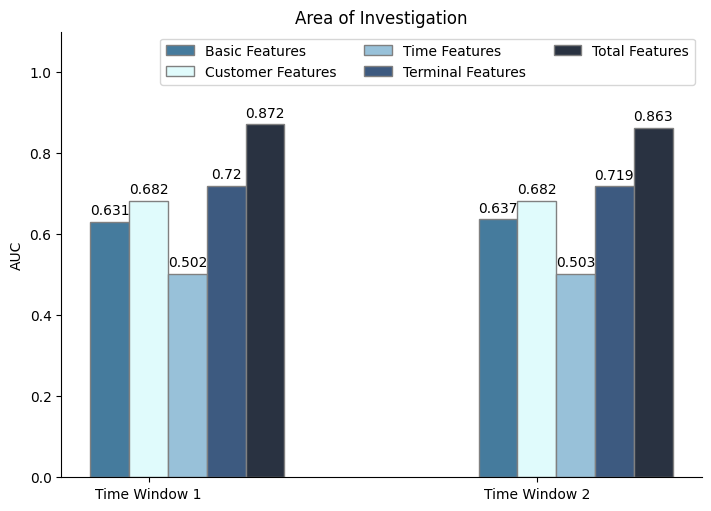

In [46]:
aucs = auc_are_feat_type["AUC"].astype(float).round(3)
# data from https://allisonhorst.github.io/palmerpenguins/
colorad = ["#457b9d","#e0fbfc", "#98c1d9", "#3d5a80","#293241"]
keycol = ['Basic Features','Customer Features','Time Features','Terminal Features','Total Features']
color_p = {k:v for k,v in zip(keycol,colorad)}
time = ("Time Window 1", "Time Window 2")
auc_means = {
    'Basic Features': (aucs["raw_features_time_folder_1"], aucs["raw_features_time_folder_2"]),
    'Customer Features':  (aucs["customer_features_time_folder_1"], aucs["customer_features_time_folder_2"]),
    'Time Features':  (aucs["time_features_time_folder_1"], aucs["time_features_time_folder_2"]),
    'Terminal Features':  (aucs["terminal_features_time_folder_1"], aucs["terminal_features_time_folder_2"]),
    'Total Features':   (aucs["total_features_time_folder_1"], aucs["total_features_time_folder_2"])
}

x = np.arange(len(time))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained',figsize=(7,5))

for attribute, measurement in auc_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=color_p[attribute],edgecolor='grey')
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('Area of Investigation')
ax.set_xticks(x + width, time)
ax.legend(loc='best', ncols=3)
ax.set_ylim(0, 1.1)
ax.spines[['right', 'top']].set_visible(False)
plt.show()
fig.savefig('auc_features.png',transparent=True)

In [ ]:
model = IsolationForest()
#________________________ SCENARIO  SPLIT ___________________________________
scenario_sensitivity = []
data_scenarios = []
for scenario in transactions_df["TX_FRAUD_SCENARIO"].unique()[1:]:
    scenario_x = scenario_sample(transactions_df,scenario)
    X_train,X_test,y_train,y_test = train_test_split_transactions(create_feature_matrix(scenario_x,
                                                                                        windows_size_in_days=[1, 5, 7, 15,30],
                                                                                        delay_period=7),
                                                                  features,
                                                                  train_start="2018-04-01", train_end="2018-07-01",
                                                                  test_start="2018-08-01",  test_end="2018-09-01",
                                                                  target="TX_FRAUD")
    
    
    # Fitting the model
    model.fit(X_train[features])
    # Reports Performance
    benchmark = evaluate_model(model, X_test, y_test)
    scenario_sensitivity.append(benchmark)
    data_scenarios.append([X_train,X_test,y_train,y_test,model])

    
scenario_sensitivity = pd.concat(scenario_sensitivity,axis=1).T
scenario_sensitivity.index = [f"scenario_{i}" for i in range(1,4)]
data_scenarios_dict = {k:v for k,v in zip([f"scenario_{i}" for i in range(1,4)],data_scenarios) } 
scenario_sensitivity
#____________________________________________________________________________

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
n =3
s = scenario_sensitivity.loc[f"scenario_{n}"].round(3)
s.index = ['isolation forest','dummy model','random guess']

time_props = f"Validation of Fraud Scenario {n}"
legend_props = "Train:04-07;Test:08-09"
my_cmap = sns.light_palette("Blue", as_cmap=True)
fig, ax = plt.subplots(layout='constrained',figsize=(10, 4))
ax.set_title(f"{time_props}")
ax.set_xlabel("AUC")
colorad = ["#457b9d", "#98c1d9", "#3d5a80"]
ax.barh(y = s.index,width = s.values, color=colorad[::-1])
ax.bar_label(ax.containers[0],fontsize=8, padding=3)
ax.spines[['right', 'top']].set_visible(False)
ax.legend([legend_props])

fig.savefig(f'auc_fraud_scenario_{n}.png',transparent=True)

In [ ]:
fig, ax = plt.subplots(layout='constrained',figsize=(6, 4))
for n,c in enumerate(["#457b9d", "#98c1d9", "#3d5a80"]):
    n+=1
    X_test =  data_scenarios_dict[f"scenario_{n}"][1]
    y_test =  data_scenarios_dict[f"scenario_{n}"][3]
    scores = -data_scenarios_dict[f"scenario_{n}"][-1].score_samples(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,scores,pos_label=1)
    auc = roc_auc_score(y_test, scores)
    ax.plot(fpr, tpr, color =  c,linestyle = "-" ,lw=2,label = f"Fraud Scenario {n}:{round(auc,3)}")
    
ax.plot(np.arange(100)/100, np.arange(100)/100, '#e63946',linestyle = "--", lw=2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f"ROC for Fraud Scenario")
ax.spines[['right', 'top']].set_visible(False)
ax.legend()
plt.show()
fig.savefig(f'roc_fraud_scenarios.png',transparent=True)